In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
!pip install -r ../requirements.txt

In [13]:
import os

target_dir = "../"
zip_file_path = "generated.zip"

if not os.path.exists(target_dir + 'generated'):
    print(f"The directory {target_dir} does not exist. Proceeding with download.")

    !apt-get update
    !apt-get install unzip
    
    !curl "https://drive.usercontent.google.com/download?id=1uBkBBph8tS7Rz2iQU8I41NSV2S9vsn_H&confirm=xxx" -o {zip_file_path}
    !mkdir -p {target_dir}
    
    !unzip {zip_file_path} -d {target_dir}
    
    print(f"File downloaded and extracted to {target_dir}")
    
    !rm {zip_file_path}
else:
    print(f"The directory {target_dir} already exists. No action taken.")

The directory ../ already exists. No action taken.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import sys
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from pathlib import Path

repo_root = Path.cwd().parent.resolve()
sys.path.append(str(repo_root))

from sklearn.model_selection import train_test_split
from src.data.auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
pairs = pd.read_csv('../generated/auction_indices.csv')
pairs.head()

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
0,2025-03-11 00:00:00,5025,6,8.00,7.12,0.00,21.00,13.33,12.71,2.00,31.00
1,2025-03-11 00:00:00,11915,3,21.67,17.17,0.00,42.00,12.00,13.59,0.00,31.00
2,2025-03-11 00:00:00,1390,5,3.80,7.11,0.00,18.00,25.00,11.03,3.00,31.00
3,2025-03-11 00:00:00,15408,4,6.75,7.79,0.00,19.00,30.00,1.73,27.00,31.00
4,2025-03-11 00:00:00,15391,4,14.00,10.39,0.00,24.00,27.00,4.00,23.00,31.00


## Prepare and balance data

In [16]:
pd.options.display.float_format = '{:.2f}'.format
pairs.describe()

,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
count,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00,3389527.00
mean,8530.84,6.25,18.29,8.39,8.42,30.12,18.44,8.32,8.67,30.14
std,4951.93,17.79,8.86,5.64,9.51,12.77,8.94,5.63,9.66,12.68
min,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4221.00,2.00,12.00,3.50,2.00,20.00,12.14,3.30,2.00,21.00
50%,8491.00,4.00,17.50,9.00,5.00,33.00,17.71,8.96,5.00,33.00
75%,12774.00,6.00,23.50,12.84,12.00,41.00,23.71,12.77,12.00,41.00
max,17197.00,707.00,49.00,25.00,49.00,50.00,49.00,24.00,49.00,50.00


In [17]:
pairs = pairs[pairs['g_hours_on_sale_max'] < 50]
pairs = pairs[pairs['g_current_hours_max'] < 50]

pairs.describe()

,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
count,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00,3389525.00
mean,8530.84,6.25,18.29,8.39,8.42,30.12,18.44,8.32,8.67,30.14
std,4951.93,17.79,8.86,5.64,9.51,12.77,8.94,5.63,9.66,12.68
min,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4221.00,2.00,12.00,3.50,2.00,20.00,12.14,3.30,2.00,21.00
50%,8491.00,4.00,17.50,9.00,5.00,33.00,17.71,8.96,5.00,33.00
75%,12774.00,6.00,23.50,12.84,12.00,41.00,23.71,12.77,12.00,41.00
max,17197.00,707.00,49.00,24.00,49.00,49.00,49.00,24.00,49.00,49.00


In [18]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.05, random_state=42, shuffle=False)

print(f"Before filtering: {len(train_pairs)}")

train_pairs = train_pairs[train_pairs['g_hours_on_sale_len'] <= 32]
val_pairs = val_pairs[val_pairs['g_hours_on_sale_len'] <= 32]

print(f"After filtering: {len(train_pairs)}\n")

# We use this to improve the performance of the model in this scenario
# train_pairs = train_pairs[train_pairs['g_current_hours_mean'] <= 12]
# val_pairs = val_pairs[val_pairs['g_current_hours_mean'] <= 12]

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

Before filtering: 3220048
After filtering: 3174203

Train pairs: 3174203
Val pairs: 167384


In [19]:
train_pairs.sample(5)

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
1479305,2025-03-14 20:00:00,9521,4,30.75,19.21,0.00,47.00,16.25,19.21,0.00,47.00
2044189,2025-03-16 09:00:00,5964,8,16.50,7.12,5.00,32.00,21.50,10.23,6.00,34.00
2451648,2025-03-17 10:00:00,9172,4,26.00,6.04,19.00,32.00,21.50,5.55,16.00,28.00
2475623,2025-03-17 12:00:00,2152,6,12.33,7.54,4.00,28.00,18.67,11.23,10.00,43.00
1432144,2025-03-14 18:00:00,10482,2,19.50,10.50,9.00,30.00,27.50,10.50,17.00,38.00


(array([ 41217.,  52899.,  54993., 101111., 120359., 138725., 186158.,
        220038., 216750., 251751., 223222., 255262., 228110., 196797.,
        172320., 153036., 112832.,  94479.,  82831.,  51492.,  49941.,
         32353.,  33631.,  26393.,  16144.,  19865.,  18416.,   9032.,
         13160.,    886.]),
 array([ 0.        ,  1.63333333,  3.26666667,  4.9       ,  6.53333333,
         8.16666667,  9.8       , 11.43333333, 13.06666667, 14.7       ,
        16.33333333, 17.96666667, 19.6       , 21.23333333, 22.86666667,
        24.5       , 26.13333333, 27.76666667, 29.4       , 31.03333333,
        32.66666667, 34.3       , 35.93333333, 37.56666667, 39.2       ,
        40.83333333, 42.46666667, 44.1       , 45.73333333, 47.36666667,
        49.        ]),
 <BarContainer object of 30 artists>)

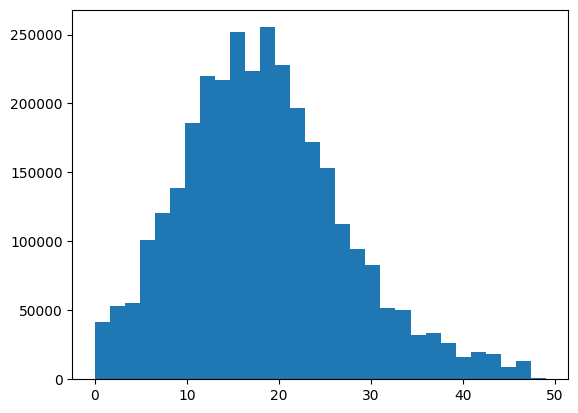

In [20]:
# histogram of group_hours_on_sale_mean
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=30)

In [21]:
val_pairs.sample(5)

,record,item_index,g_hours_on_sale_len,g_hours_on_sale_mean,g_hours_on_sale_std,g_hours_on_sale_min,g_hours_on_sale_max,g_current_hours_mean,g_current_hours_std,g_current_hours_min,g_current_hours_max
3290265,2025-03-19 17:00:00,4140,7,21.00,12.52,0.00,34.00,19.14,12.29,5.00,47.00
3229502,2025-03-19 11:00:00,212,2,17.50,15.50,2.00,33.00,29.00,15.00,14.00,44.00
3382347,2025-03-19 23:00:00,11840,4,29.75,7.89,18.00,40.00,17.00,8.22,6.00,29.00
3285914,2025-03-19 17:00:00,8883,3,12.67,6.24,6.00,21.00,26.33,18.08,1.00,42.00
3225142,2025-03-19 11:00:00,6290,4,7.75,8.67,0.00,21.00,13.00,14.95,1.00,38.00


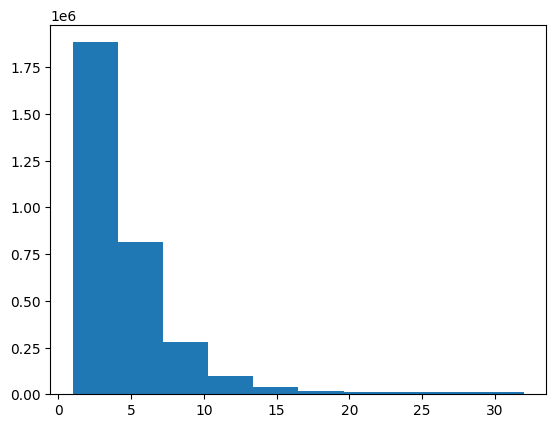

In [22]:
plt.hist(train_pairs['g_hours_on_sale_len'], bins=10)
plt.show()

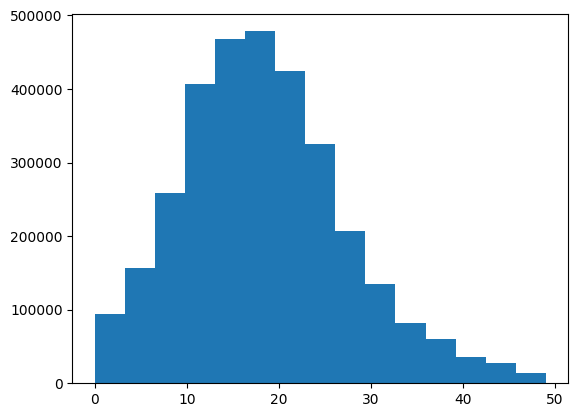

In [23]:
plt.hist(train_pairs['g_hours_on_sale_mean'], bins=15)
plt.show()

In [24]:
import json
import os

mappings_dir = '../generated/mappings'

with open(os.path.join(mappings_dir, 'item_to_idx.json'), 'r') as f:
    item_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'context_to_idx.json'), 'r') as f:
    context_to_idx = json.load(f)
    
with open(os.path.join(mappings_dir, 'bonus_to_idx.json'), 'r') as f:
    bonus_to_idx = json.load(f)

with open(os.path.join(mappings_dir, 'modtype_to_idx.json'), 'r') as f:
    modtype_to_idx = json.load(f)

In [25]:
from src.data.auction_dataset import AuctionDataset
from src.data.utils import collate_auctions

batch_size = 128

train_dataset = AuctionDataset(train_pairs, feature_stats_path='../generated/feature_stats.pt', path='../generated/sequences.h5')
val_dataset = AuctionDataset(val_pairs, feature_stats_path='../generated/feature_stats.pt', path='../generated/sequences.h5')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=8, prefetch_factor=8, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=8, prefetch_factor=8, pin_memory=True)

Dataset size: 3174203
Dataset size: 167384


## Model definition

In [26]:
test_data_loader = True

if test_data_loader:
    iter_loader = iter(train_dataloader)
    (auctions, item_index, contexts, bonus_lists, modifier_types, modifier_values), y = next(iter_loader)

    print(f'auctions: {auctions.shape}')
    print(f'item_index: {item_index.shape}')
    print(f'contexts: {contexts.shape}')
    print(f'bonus_lists: {bonus_lists.shape}')
    print(f'modifier_types: {modifier_types.shape}')
    print(f'modifier_values: {modifier_values.shape}')
    print(f'y: {y.shape}')

auctions: torch.Size([128, 21, 7])
item_index: torch.Size([128, 21])
contexts: torch.Size([128, 21])
bonus_lists: torch.Size([128, 21, 5])
modifier_types: torch.Size([128, 21, 2])
modifier_values: torch.Size([128, 21, 2])
y: torch.Size([128, 21])


In [28]:
from src.models.auction_transformer import AuctionTransformer

input_size = 7
embedding_dim = 16
d_model = 128
dim_feedforward = d_model * 4
nhead = 8
num_layers = 8
dropout_p = 0.0
n_items = len(item_to_idx)
n_contexts = len(context_to_idx)
n_bonuses = len(bonus_to_idx)
n_modtypes = len(modtype_to_idx)

model = AuctionTransformer(
    input_size, 
    n_items, 
    n_contexts,
    n_bonuses,
    n_modtypes,
    embedding_dim, 
    d_model, 
    dim_feedforward, 
    nhead, 
    num_layers,
    dropout_p=dropout_p,
    learning_rate=3e-5,
    logging_interval=500
)

print(sum(p.numel() for p in model.parameters()))

1957313


## Training

In [29]:
!rm -rf logs/train
!rm -rf logs/val

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

name = "tf_auctions_2.0M"

logger = TensorBoardLogger( # tensorboard --logdir=logs
    save_dir="logs",
    name=name,
    version='full_train-128b-wpos'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='../models/auction_transformer_2.0M_128b_wpos',
    filename='epoch_{epoch:02d}',
    save_top_k=-1,
    every_n_epochs=1,
    save_last=True
)

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=10,
    logger=logger,
    limit_val_batches=300,
    val_check_interval=0.1,  # Validate every 25% of training epoch
    callbacks=[checkpoint_callback]
)

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-22 20:19:22.192794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 20:19:22.266802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 20:19:22.287859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/angel/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Overfit on single batch

!rm -rf logs/train
!rm -rf logs/val

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

name = "tf_auctions_2.0M"

logger = TensorBoardLogger( # tensorboard --logdir=logs
    save_dir="logs",
    name=name,
    version='overfit'
)

trainer = L.Trainer(
    max_epochs=1000,
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,
    logger=logger,
    limit_train_batches=1,  # Overfit on single batch
    limit_val_batches=1,
    val_check_interval=1,
    overfit_batches=1
)

trainer.fit(model, train_dataloader, val_dataloader)